In [1]:
import numpy as np

from sklearn.datasets import load_iris, load_boston
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

from alibi.explainers import PartialDependence, PDEstimatorWrapper, plot_pd
from alibi.datasets import fetch_adult

%load_ext autoreload
%autoreload 2

### Iris dataset

In [2]:
# load dataset
dataset = load_iris()
X, y = dataset['data'], dataset['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [3]:
# train random forest classifier
rf_classifier = RandomForestClassifier()
rf_classifier.fit(X_train, y_train)

print('Train accuracy: %.2f' % (rf_classifier.score(X_train, y_train)))
print('Test accuracy: %.2f' % (rf_classifier.score(X_test, y_test)))

Train accuracy: 1.00
Test accuracy: 1.00


In [4]:
# compute partial dependence
pd_classifier = PartialDependence(predictor=rf_classifier)
exp_classifier = pd_classifier.explain(X=X_train,
                                       features_list=[0, 1, 2, 3],
                                       kind='both')

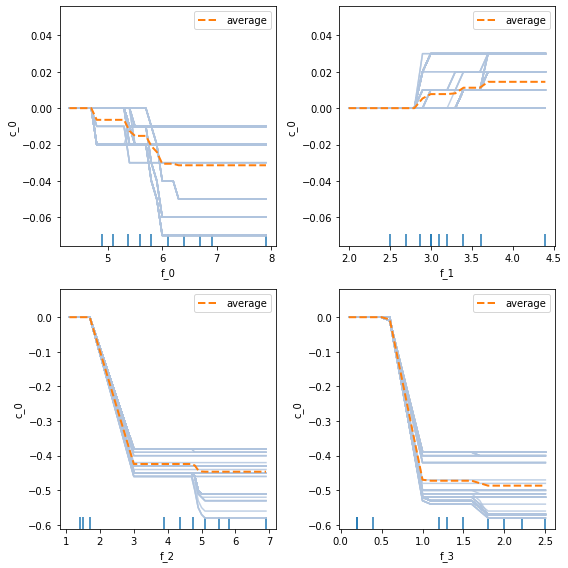

In [5]:
# plot one way pd
plot_pd(exp=exp_classifier,
        features_list='all',
        target_idx=0,
        n_cols=2,
        sharey='row',
        fig_kw = {'figheight': 8, 'figwidth': 8});

In [6]:
# compute two way pd
exp_classifier = pd_classifier.explain(X=X_train,
                                       features_list=[(0, 1), (1, 2), (2, 3)],
                                       kind='average')

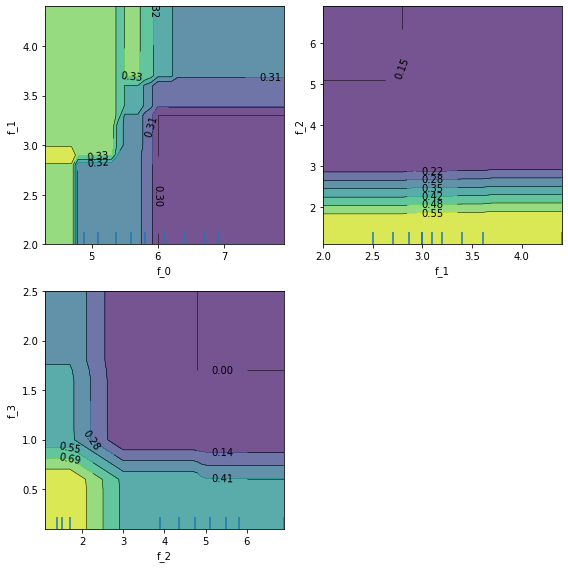

In [7]:
# plot one way pd
plot_pd(exp=exp_classifier,
        features_list='all',
        target_idx=0,
        n_cols=2,
        sharey='row',
        fig_kw = {'figheight': 8, 'figwidth': 8});

### Boston dataset

In [8]:
# load dataset
dataset = load_boston()
X, y = dataset['data'], dataset['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np


        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the California housing dataset (i.e.
    :func:`~sklearn.datasets.fetch_california_housing`) and the Ames housing
    datas

In [9]:
# train random forest classifier
rf_regressor = RandomForestRegressor()
rf_regressor.fit(X_train, y_train)

print('Train accuracy: %.2f' % (rf_regressor.score(X_train, y_train)))
print('Test accuracy: %.2f' % (rf_regressor.score(X_test, y_test)))

Train accuracy: 0.98
Test accuracy: 0.78


In [10]:
# compute partial dependence
pd_regressor = PartialDependence(predictor=rf_regressor)
exp_regressor = pd_regressor.explain(X=X_train,
                                     percentiles=(0, 1),
                                     grid_resolution=20,
                                     features_list=[0, 1, 2, 3, (0, 1), (2, 3)],
                                     kind='average')

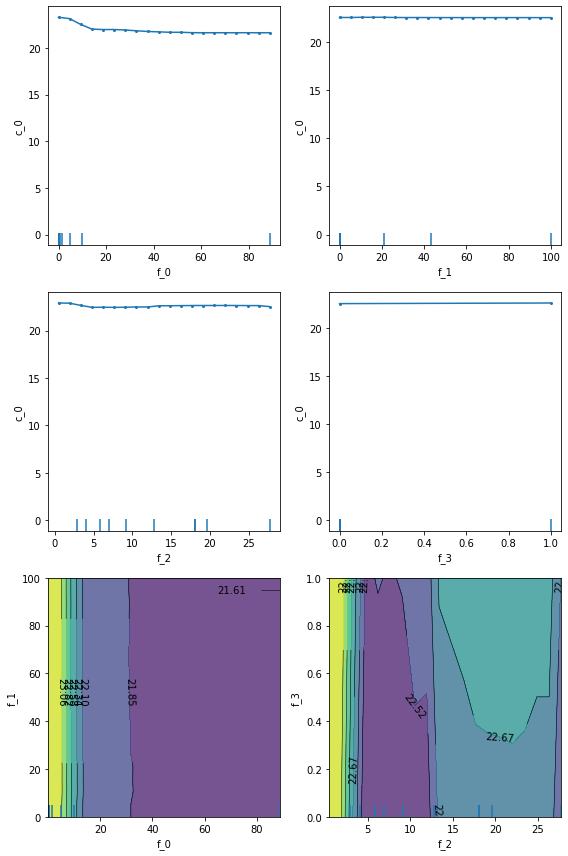

In [11]:
# plot one way pd
plot_pd(exp=exp_regressor,
        features_list='all',
        target_idx=0,
        n_cols=2,
        sharey=None,
        fig_kw = {'figheight': 12, 'figwidth': 8});

In [12]:
exp_regressor = pd_regressor.explain(X=X_train[:100],
                                     percentiles=(0, 1),
                                     grid_resolution=20,
                                     features_list=[0, 1, 2, 3],
                                     kind='both')

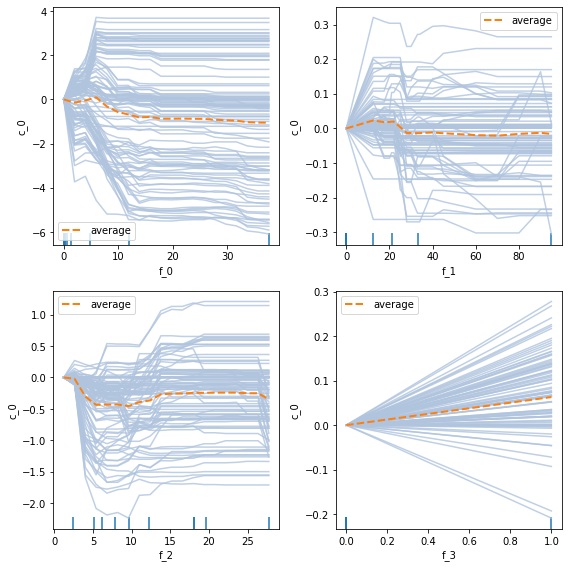

In [13]:
# plot one way pd
plot_pd(exp=exp_regressor,
        features_list='all',
        target_idx=0,
        n_cols=2,
        centered=True,
        sharey=None,
        fig_kw = {'figheight': 8, 'figwidth': 8});

### Black box - classifier

In [14]:
# load dataset
dataset = load_iris()
X, y = dataset['data'], dataset['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [15]:
# train random forest classifier
lr_classifier = LogisticRegression(max_iter=1000)
lr_classifier.fit(X_train, y_train)

print('Train accuracy: %.2f' % (lr_classifier.score(X_train, y_train)))
print('Test accuracy: %.2f' % (lr_classifier.score(X_test, y_test)))

Train accuracy: 0.97
Test accuracy: 1.00


In [16]:
# define black-box predictor
predictor = lr_classifier.predict_proba

In [17]:
wrapped_predictor = PDEstimatorWrapper(predictor=predictor,
                                       predictor_type='classifier',
                                       prediction_fn='predict_proba',
                                       num_classes=len(np.unique(y_train)))

In [18]:
# compute partial dependence
pd_blackbox = PartialDependence(predictor=wrapped_predictor)
exp_blackbox = pd_blackbox.explain(X=X_train[:100],
                                   percentiles=(0, 1),
                                   grid_resolution=20,
                                   features_list=[0, 1, 2, 3],
                                   kind='both')

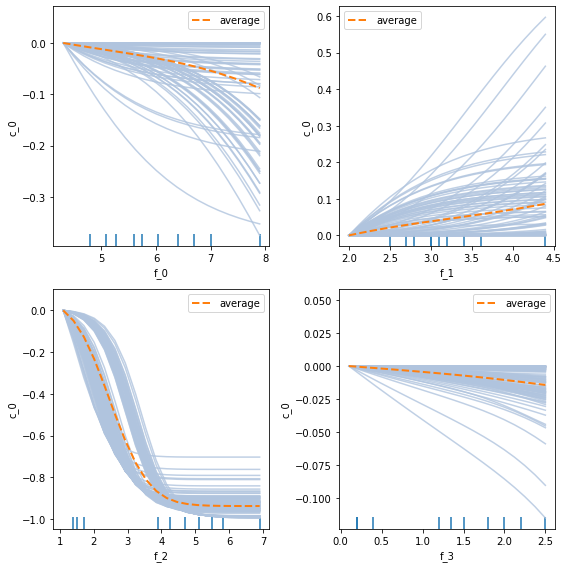

In [19]:
# plot one way pd
plot_pd(exp=exp_blackbox,
        features_list='all',
        target_idx=0,
        n_cols=2,
        sharey=None,
        fig_kw = {'figheight': 8, 'figwidth': 8});

### Adult dataset

In [20]:
# fetch adult datasets
adult = fetch_adult()

# split dataset into train-test-validation
X, y = adult.data, adult.target
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=1000, test_size=2000, random_state=13)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=13)

# identify numerical and categorical columns
categorical_ids = list(adult.category_map.keys())
numerical_ids = [i for i in range(len(adult.feature_names)) if i not in adult.category_map]

In [21]:
# define data preprocessor
num_transf = StandardScaler()
cat_transf = OneHotEncoder(
    categories=[range(len(x)) for x in adult.category_map.values()],
    drop='first',
)
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', cat_transf, categorical_ids),
        ('num', num_transf, numerical_ids)
    ],
    sparse_threshold=0
)

# fit data preprocessor
preprocessor = preprocessor.fit(adult.data)

In [22]:
X_train_ohe = preprocessor.transform(X_train)
X_test_ohe = preprocessor.transform(X_test)

In [23]:
rf_classifier = RandomForestClassifier()
rf_classifier.fit(X_train_ohe, y_train)

RandomForestClassifier()

In [24]:
print('Train accuracy: %.2f' % (rf_classifier.score(X_train_ohe, y_train)))
print('Test accuracy: %.2f' % (rf_classifier.score(X_test_ohe, y_test)))

Train accuracy: 1.00
Test accuracy: 0.83


In [25]:
def decorator(func):
    def wrapper(X: np.ndarray, *args, **kwargs):
        X_ohe = preprocessor.transform(X)
        return func(X_ohe, *args, *kwargs)
    return wrapper

In [26]:
# decorate predict proba
rf_classifier.predict_proba = decorator(rf_classifier.predict_proba)

In [27]:
explainer = PartialDependence(predictor=rf_classifier,
                              feature_names=adult.feature_names,
                              categorical_names=adult.category_map)

In [28]:
exp1 = explainer.explain(X=X_train[:100], 
                        features_list=[0, 1, (0, 1), (2, 3)],
                        response_method='predict_proba',
                        percentiles=(0, 1),
                        method='auto',
                        kind='average')

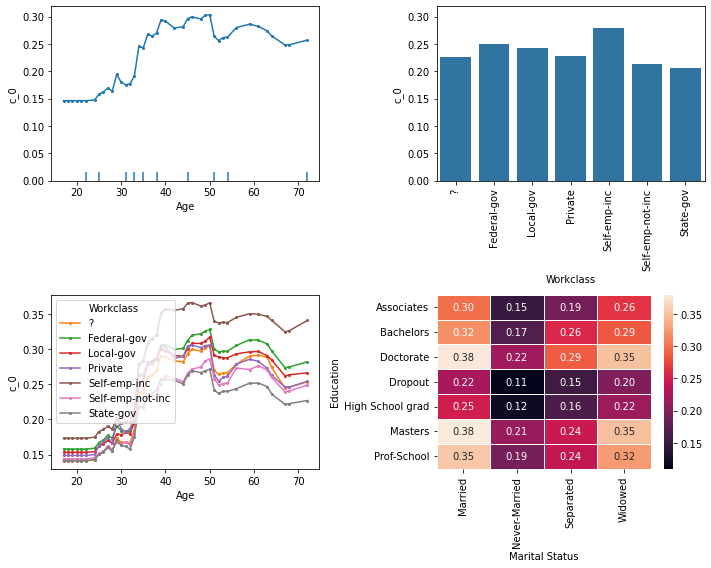

In [30]:
plot_pd(exp=exp1,
        features_list='all',
        target_idx=0,
        n_cols=2,
        sharey='row',
        fig_kw={'figheight': 8, 'figwidth': 10});

In [44]:
exp2 = explainer.explain(X=X_train[:100], 
                        features_list=numerical_ids,
                        response_method='predict_proba',
                        percentiles=(0, 1),
                        method='auto',
                        kind='both')

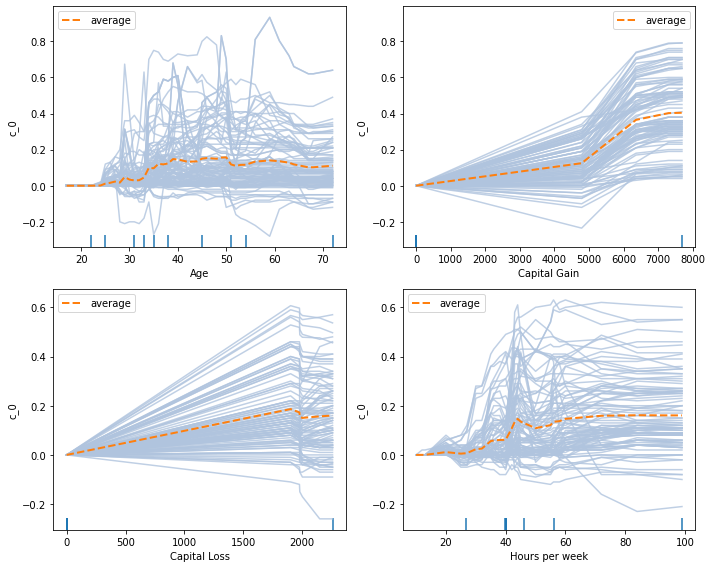

In [46]:
plot_pd(exp=exp2,
        features_list='all',
        target_idx=0,
        n_cols=2,
        sharey='row',
        fig_kw={'figheight': 8, 'figwidth': 10});

In [48]:
exp3 = explainer.explain(X=X_train[:100], 
                        features_list=[3, 5, 7],
                        response_method='predict_proba',
                        percentiles=(0, 1),
                        method='auto',
                        kind='both')

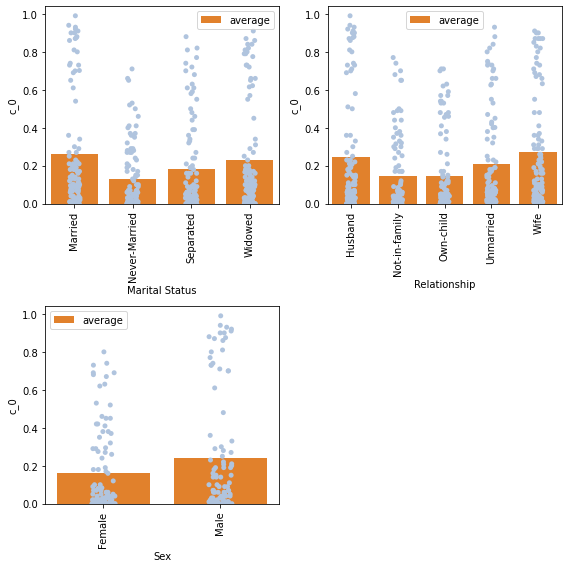

In [53]:
plot_pd(exp=exp3,
        features_list='all',
        target_idx=0,
        n_cols=2,
        sharey='row',
        fig_kw={'figheight': 8, 'figwidth': 8});

In [61]:
ft_list = [adult.feature_names.index('Education'), adult.feature_names.index('Marital Status')]
ft_list

[2, 3]

In [64]:
exp4 = explainer.explain(X=X_train[:100], 
                        features_list=[(2, 3), 2, 3],
                        response_method='predict_proba',
                        percentiles=(0, 1),
                        method='auto',
                        kind='average')

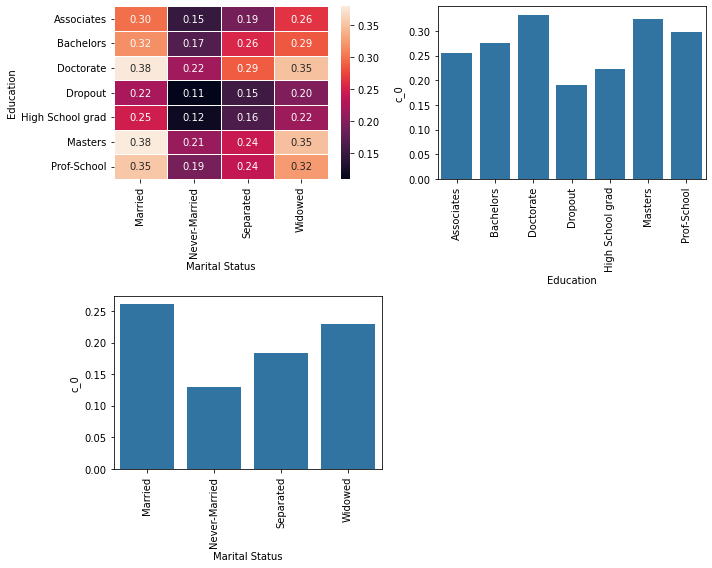

In [68]:
plot_pd(exp=exp4,
        features_list='all',
        target_idx=0,
        n_cols=2,
        sharey='row',
        fig_kw={'figheight': 8, 'figwidth': 10});

In [83]:
exp5 = explainer.explain(X=X_train[:5000], 
                        features_list=[(0, 10), 8, 10, 0],
                        response_method='predict_proba',
                        percentiles=(0, 1),
                        grid_resolution=50,
                        method='auto',
                        kind='average')

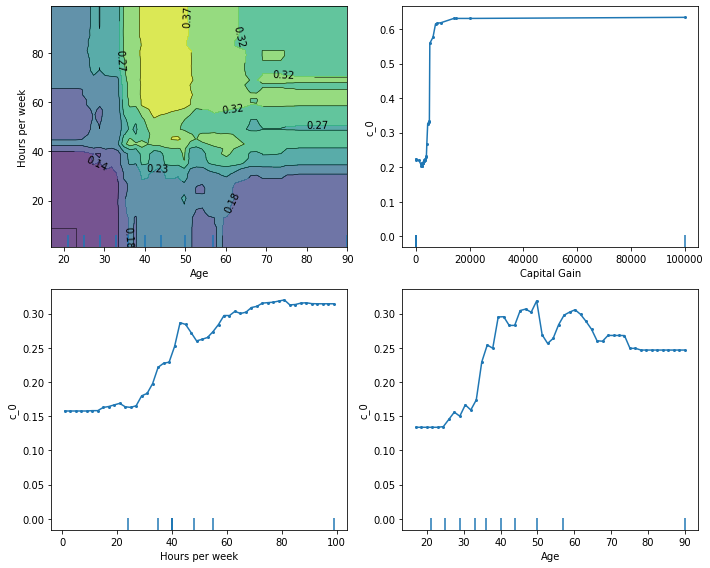

In [84]:
plot_pd(exp=exp5,
        features_list='all',
        target_idx=0,
        n_cols=2,
        sharey='row',
        fig_kw={'figheight': 8, 'figwidth': 10});